<a href="https://colab.research.google.com/github/SXV357/Inspirit-AI-Deep-Drive-Designing-DL-Systems-Notebooks/blob/main/LungSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, concatenate, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
import gdown
from ipywidgets import interact, IntSlider

IMG_PATH = "reduced/imgs"
MASK_PATH = "reduced/masks"
EPOCHS = 40

!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Common%20Files/Lung%20Segmentation%20Notebook/reduced.zip"
!unzip -oq reduced.zip

np.random.seed(12)
tf.random.set_seed(12)

def load():
    imgs_paths = sorted([Path(IMG_PATH) / p for p in os.listdir(IMG_PATH)])
    masks_paths = sorted([Path(MASK_PATH) / p for p in os.listdir(MASK_PATH)])
    imgs = [plt.imread(p) for p in imgs_paths]
    masks = [plt.imread(p)[:, :, 0][:, :, None] > 0.5 for p in masks_paths]
    imgs, masks = np.array(imgs)[:,:,:,0:1], np.array(masks).astype(float)
    imgs_train, imgs_test, masks_train, masks_test = train_test_split(
        imgs, masks, test_size=0.2, shuffle=False
    )
    return imgs_train, imgs_test, masks_train, masks_test

def show_lung_mask_sbs(lung, mask):
    fig, (a1, a2) = plt.subplots(1, 2)
    a1.imshow(lung.squeeze(), cmap = 'gray')
    a2.imshow(mask.squeeze(), cmap = 'gray')
    a1.set_title("lung")
    a2.set_title("mask")


def show_lung_mask_pred_sbs(lung, mask, pred):
    fig, (a1, a2, a3) = plt.subplots(1, 3)
    a1.imshow(lung.squeeze(), cmap = 'gray')
    a2.imshow(mask.squeeze(), cmap = 'gray')
    a3.imshow(pred.squeeze(), cmap = 'gray')
    a1.set_title("lung")
    a2.set_title("mask")
    a3.set_title("predicted mask")

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - numerator / denominator

class ShowLearning(tf.keras.callbacks.Callback):
    def __init__(self, data, masks, name):
        self.data = data
        self.masks = masks
        self.fig_path = f"lung/figs/{name}"
        if not os.path.exists(self.fig_path):
            os.makedirs(self.fig_path)
        super().__init__()

    def on_epoch_begin(self, epoch, logs=None):
        rand_index = np.random.randint(0, len(self.data))
        rand_img = self.data[rand_index][None, :, :, :]
        mask = self.masks[rand_index][None, :, :, :]
        preds = self.model(rand_img).numpy() > 0.5
        show_lung_mask_pred_sbs(rand_img, mask, preds)
        plt.savefig(f"{self.fig_path}/epoch{epoch}.png")
        plt.close()

def show_training_image(name, epoch):
  im = plt.imread(f'lung/figs/{name}/epoch{epoch}.png')
  plt.imshow(im)

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - numerator / denominator

--2022-08-13 05:07:51--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Common%20Files/Lung%20Segmentation%20Notebook/reduced.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1437853 (1.4M) [application/zip]
Saving to: ‘reduced.zip’

reduced.zip         100%[===================>]   1.37M  --.-KB/s    in 0.008s  

2022-08-13 05:07:52 (172 MB/s) - ‘reduced.zip’ saved [1437853/1437853]



In [2]:
imgs_train, imgs_test, masks_train, masks_test = load()
print(imgs_train.shape, imgs_test.shape, masks_train.shape, masks_test.shape)
# 64 x 64 - width and height, 213 images in both training datasets, and 54 in testing datasets
# black and white images because of 1 color channel(lightness/darkness of a pixel)

(213, 64, 64, 1) (54, 64, 64, 1) (213, 64, 64, 1) (54, 64, 64, 1)


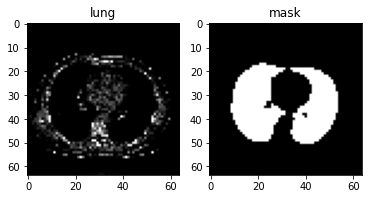

In [3]:
img_num = 20
show_lung_mask_sbs(imgs_train[img_num], masks_train[img_num])

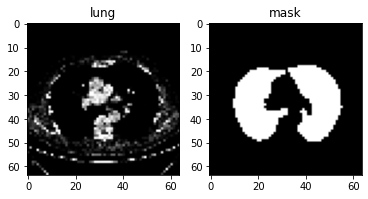

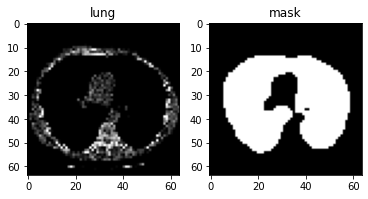

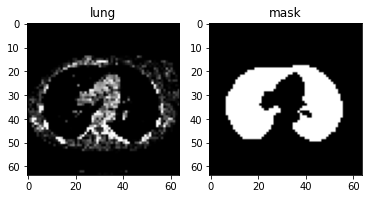

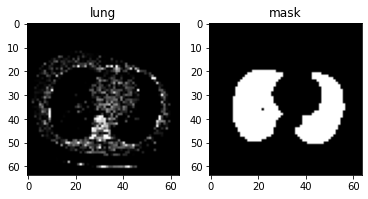

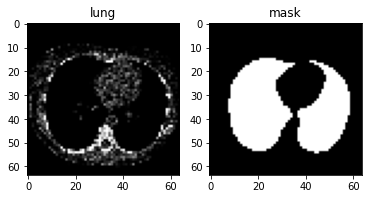

In [4]:
img_li = [0,1,2,3,4]
for i in range(len(img_li)):
  show_lung_mask_sbs(imgs_train[img_li[i]], masks_train[img_li[i]])

In [6]:
def SimpleConvModel():
    model = tf.keras.models.Sequential(
        [
            Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation='relu'),
            Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same', activation='relu'),
            Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation='relu'),
            Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation='relu'),
            Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same', activation='relu'),
            Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same', activation='relu'),
            Conv2D(filters = 1, kernel_size = 3, strides = 1, padding="same", activation="sigmoid"),
        ]
    ) 
    return model

model = SimpleConvModel()

In [7]:
def train(model, imgs, masks, loss, name, epochs):
    optimizer = tf.optimizers.Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    model.fit(imgs, masks, epochs=epochs, callbacks=[ShowLearning(imgs, masks, name)],)

train(model, imgs_train, masks_train, tf.losses.BinaryCrossentropy(), 'simple_conv', EPOCHS)

Epoch 1/40
4/7 [================>.............] - ETA: 0s - loss: 0.6910 - accuracy: 0.7274 

7/7 [==============================] - 4s 72ms/step - loss: 0.6890 - accuracy: 0.7432
Epoch 2/40
7/7 [==============================] - 0s 17ms/step - loss: 0.6739 - accuracy: 0.7662
Epoch 3/40
7/7 [==============================] - 0s 17ms/step - loss: 0.6443 - accuracy: 0.7662
Epoch 4/40
7/7 [==============================] - 0s 16ms/step - loss: 0.5933 - accuracy: 0.7662
Epoch 5/40
7/7 [==============================] - 0s 17ms/step - loss: 0.5619 - accuracy: 0.7662
Epoch 6/40
7/7 [==============================] - 0s 18ms/step - loss: 0.5575 - accuracy: 0.7662
Epoch 7/40
7/7 [==============================] - 0s 17ms/step - loss: 0.5503 - accuracy: 0.7662
Epoch 8/40
7/7 [==============================] - 0s 17ms/step - loss: 0.5443 - accuracy: 0.7662
Epoch 9/40
7/7 [==============================] - 0s 17ms/step - loss: 0.5369 - accuracy: 0.7662
Epoch 10/40
7/7 [==============================] - 0s 18ms/step - loss: 0.5288 - accuracy: 0.7662
Epoch 11/40
7/7 [=======================

In [8]:
model.summary() # size remains the same, narrowed to 1 single pattern after being passed through multiple layers

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 1)        

In [9]:
interact(lambda epoch: show_training_image('simple_conv', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

In [10]:
round((masks_train.sum()/masks_train.size) * 100, 2)
# pixels part of the lung / total number of pixels in mask image multiplied by 100

23.38

In [11]:
# Dice coefficient implementation
# formula = 2 * overlap between pixels truly in lung and those predicted to be part of lung / sum of pixels in lung + sum of pixels predicted to be in lung

def dice(true_mask, predicted_mask):
    #flatten the data
    true_mask, predicted_mask = true_mask.astype(bool).flatten(), predicted_mask.astype(bool).flatten()
    
    return 2 * sum(true_mask & predicted_mask) / (sum(true_mask) + sum(predicted_mask))

Jaccard Index score: 0.7
Jaccard Index score: 0.54
Jaccard Index score: 0.75
Jaccard Index score: 0.58
Jaccard Index score: 0.61
Jaccard Index score: 0.63
Jaccard Index score: 0.71
Jaccard Index score: 0.59
Jaccard Index score: 0.68
Jaccard Index score: 0.67
Jaccard Index score: 0.63


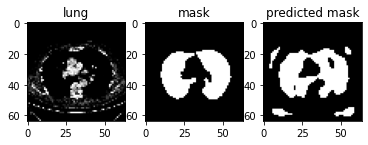

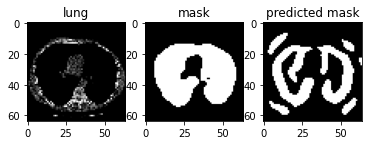

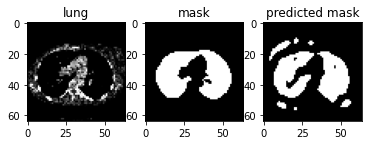

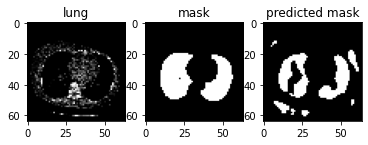

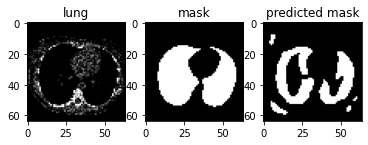

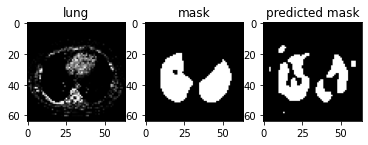

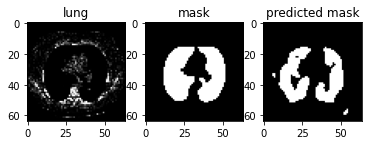

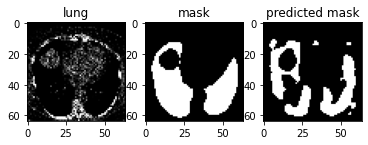

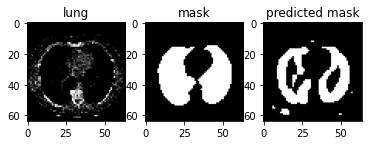

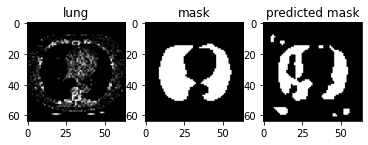

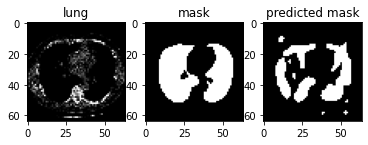

In [12]:
def jaccard(true_mask, predicted_mask):
  true_mask, predicted_mask = true_mask.astype(bool).flatten(), predicted_mask.astype(bool).flatten()
  return sum(true_mask & predicted_mask) / (sum(true_mask) + sum(predicted_mask) - sum(true_mask & predicted_mask))

def calc_jaccard():
  for i in range(0, 11): 
    new_img = np.expand_dims(imgs_train[i], 0)
    true_mask = masks_train[i]
    mask_pred = model.predict(new_img) > 0.275

    show_lung_mask_pred_sbs(new_img, true_mask, mask_pred)
    print(f'Jaccard Index score: {round(jaccard(true_mask, mask_pred), 2)}')

calc_jaccard()

Dice score: 0.6063902107409925


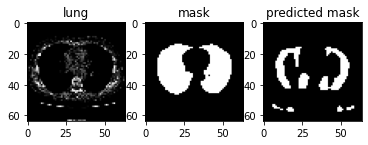

In [13]:
img_num = 100

img = np.expand_dims(imgs_train[img_num],0)
true_mask = masks_train[img_num]
pred_mask = model.predict(img) > 0.5

show_lung_mask_pred_sbs(img, true_mask, pred_mask)

print("Dice score:", dice(true_mask, pred_mask))

In [14]:
model_with_dice = SimpleConvModel()
train(model_with_dice, imgs_train, masks_train, dice_loss, 'simple_conv_with_dice', EPOCHS)

Epoch 1/40
5/7 [====================>.........] - ETA: 0s - loss: 0.6853 - accuracy: 0.3489

7/7 [==============================] - 1s 29ms/step - loss: 0.6860 - accuracy: 0.3196
Epoch 2/40
7/7 [==============================] - 0s 24ms/step - loss: 0.6842 - accuracy: 0.2338
Epoch 3/40
7/7 [==============================] - 0s 22ms/step - loss: 0.6799 - accuracy: 0.2338
Epoch 4/40
7/7 [==============================] - 0s 17ms/step - loss: 0.6692 - accuracy: 0.2338
Epoch 5/40
7/7 [==============================] - 0s 17ms/step - loss: 0.6481 - accuracy: 0.2338
Epoch 6/40
7/7 [==============================] - 0s 17ms/step - loss: 0.6264 - accuracy: 0.2338
Epoch 7/40
7/7 [==============================] - 0s 17ms/step - loss: 0.6183 - accuracy: 0.2339
Epoch 8/40
7/7 [==============================] - 0s 18ms/step - loss: 0.5947 - accuracy: 0.3809
Epoch 9/40
7/7 [==============================] - 0s 17ms/step - loss: 0.5769 - accuracy: 0.4439
Epoch 10/40
7/7 [==============================] - 0s 17ms/step - loss: 0.5663 - accuracy: 0.4533
Epoch 11/40
7/7 [=======================

In [15]:
interact(lambda epoch: show_training_image('simple_conv_with_dice', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

In [16]:
# U-Net Implementation
def section(conv1_filters, conv2_filters): #Represents one horizontal "section" of the U
    return tf.keras.Sequential(
        [
            Conv2D(conv1_filters, 3, padding="same", activation="relu"),
            Conv2D(conv2_filters, 3, padding="same", activation="relu"),
        ]
    )

class U_Net(tf.keras.Model):
    def __init__(self):
        super(U_Net, self).__init__()
        self.section1 = section(16, 16)
        self.section2 = section(32, 32)
        self.section3 = section(32, 64) #Bottom of the U!
        self.section4 = section(32, 32)
        self.section5 = section(16, 16)
        self.final_conv = Conv2D(1, 3, padding="same", activation="sigmoid")
        self.maxpool1, self.maxpool2 = MaxPool2D(2), MaxPool2D(2)
        self.upsample1, self.upsample2 = UpSampling2D(2), UpSampling2D(2)

    def call(self, inputs):
        input1 = self.section1(inputs)
        input2 = self.section2(self.maxpool1(input1))
        input3 = self.section3(self.maxpool2(input2))
        input4 = self.section4(concatenate([input2, self.upsample1(input3)]))
        input5 = self.section5(concatenate([input1, self.upsample2(input4)]))
        output = self.final_conv(input5)
        return output

unet = U_Net()
train(unet, imgs_train, masks_train, dice_loss, 'unet_with_dice', epochs=EPOCHS)

Epoch 1/40
7/7 [==============================] - 2s 70ms/step - loss: 0.6859 - accuracy: 0.3340
Epoch 2/40
7/7 [==============================] - 0s 17ms/step - loss: 0.6816 - accuracy: 0.2362
Epoch 3/40
7/7 [==============================] - 0s 17ms/step - loss: 0.6580 - accuracy: 0.2338
Epoch 4/40
7/7 [==============================] - 0s 18ms/step - loss: 0.6088 - accuracy: 0.2338
Epoch 5/40
7/7 [==============================] - 0s 18ms/step - loss: 0.6062 - accuracy: 0.2338
Epoch 6/40
7/7 [==============================] - 0s 17ms/step - loss: 0.5965 - accuracy: 0.2572
Epoch 7/40
7/7 [==============================] - 0s 18ms/step - loss: 0.5857 - accuracy: 0.2666
Epoch 8/40
7/7 [==============================] - 0s 18ms/step - loss: 0.5604 - accuracy: 0.4370
Epoch 9/40
7/7 [==============================] - 0s 18ms/step - loss: 0.4798 - accuracy: 0.7786
Epoch 10/40
7/7 [==============================] - 0s 18ms/step - loss: 0.3338 - accuracy: 0.8769
Epoch 11/40
7/7 [============

In [17]:
interact(lambda epoch: show_training_image('unet_with_dice', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

In [18]:
thresh = 0.5
preds = unet(imgs_test).numpy()
preds = preds >= thresh

def show_preds_helper(imgs_test, masks_test, preds, ind):
    show_lung_mask_pred_sbs(imgs_test[ind], masks_test[ind], preds[ind])
    plt.show()

interact(lambda i: show_preds_helper(imgs_test, masks_test, preds, i), i=(0, len(preds)-1));

interactive(children=(IntSlider(value=26, description='i', max=53), Output()), _dom_classes=('widget-interact'…

In [19]:
# Improving model
def section(conv1_filters, conv2_filters, conv3_filters, conv4_filters): #Represents one horizontal "section" of the U
    return tf.keras.Sequential(
        [
            Conv2D(conv1_filters, 3, padding="same", activation="relu"),
            Conv2D(conv2_filters, 3, padding="same", activation="relu"),
            Conv2D(conv3_filters, 3, padding = "same", activation = "relu"),
            Conv2D(conv4_filters, 3, padding = "same", activation = "relu"),
        ]
    )

class U_Net(tf.keras.Model):
    def __init__(self):
        super(U_Net, self).__init__()
        self.section1 = section(16, 16, 16, 16)
        self.section2 = section(32, 32, 32, 32)
        self.section3 = section(32, 64, 64, 32) #Bottom of the U!
        self.section4 = section(32, 32, 32, 32)
        self.section5 = section(16, 16, 16, 16)
        self.dense1, self.dense2 = tf.keras.layers.Dense(15, activation = tf.nn.relu), tf.keras.layers.Dense(30, activation = tf.nn.relu)
        self.dense3, self.dense4 = tf.keras.layers.Dense(60, activation = tf.nn.relu), tf.keras.layers.Dense(120, activation = tf.nn.relu)
        self.final_conv = Conv2D(1, 3, padding="same", activation="sigmoid") # sigmoid for binary classification, softmax for multi class classification
        self.maxpool1, self.maxpool2 = MaxPool2D(2), MaxPool2D(2) 
        self.upsample1, self.upsample2 = UpSampling2D(2), UpSampling2D(2)

    def call(self, inputs):
        input1 = self.section1(inputs)
        input2 = self.section2(self.maxpool1(input1))
        input3 = self.section3(self.maxpool2(input2))
        input4 = self.section4(concatenate([input2, self.upsample1(input3)]))
        input5 = self.section5(concatenate([input1, self.upsample2(input4)]))
        output = self.final_conv(input5)
        return output

new_uNet = U_Net()
train(new_uNet, imgs_train, masks_train, dice_loss, 'unet_with_dice', epochs=50)

Epoch 1/50
5/7 [====================>.........] - ETA: 0s - loss: 0.6849 - accuracy: 0.2375

7/7 [==============================] - 2s 49ms/step - loss: 0.6855 - accuracy: 0.2359
Epoch 2/50
7/7 [==============================] - 0s 29ms/step - loss: 0.6741 - accuracy: 0.2338
Epoch 3/50
7/7 [==============================] - 0s 29ms/step - loss: 0.6114 - accuracy: 0.2338
Epoch 4/50
7/7 [==============================] - 0s 29ms/step - loss: 0.6005 - accuracy: 0.2338
Epoch 5/50
7/7 [==============================] - 0s 29ms/step - loss: 0.5771 - accuracy: 0.2338
Epoch 6/50
7/7 [==============================] - 0s 29ms/step - loss: 0.5421 - accuracy: 0.2338
Epoch 7/50
7/7 [==============================] - 0s 29ms/step - loss: 0.5204 - accuracy: 0.3444
Epoch 8/50
7/7 [==============================] - 0s 29ms/step - loss: 0.5101 - accuracy: 0.7389
Epoch 9/50
7/7 [==============================] - 0s 30ms/step - loss: 0.4477 - accuracy: 0.8615
Epoch 10/50
7/7 [==============================] - 0s 28ms/step - loss: 0.2829 - accuracy: 0.8784
Epoch 11/50
7/7 [=======================

In [20]:
new_thresh = 0.55 
preds = new_uNet(imgs_test).numpy()
preds = preds >= new_thresh

def show_preds_helper(imgs_test, masks_test, preds, ind):
    show_lung_mask_pred_sbs(imgs_test[ind], masks_test[ind], preds[ind])
    plt.show()

interact(lambda i: show_preds_helper(imgs_test, masks_test, preds, i), i=(0, len(preds)-1));

interactive(children=(IntSlider(value=26, description='i', max=53), Output()), _dom_classes=('widget-interact'…

Epoch 1/50
7/7 [==============================] - 1s 203ms/step - loss: 0.0709 - accuracy: 0.9687 - val_loss: 0.0765 - val_accuracy: 0.9641
Epoch 2/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0709 - accuracy: 0.9691 - val_loss: 0.0745 - val_accuracy: 0.9649
Epoch 3/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0694 - accuracy: 0.9695 - val_loss: 0.0739 - val_accuracy: 0.9648
Epoch 4/50
7/7 [==============================] - 0s 34ms/step - loss: 0.0666 - accuracy: 0.9708 - val_loss: 0.0727 - val_accuracy: 0.9654
Epoch 5/50
7/7 [==============================] - 0s 34ms/step - loss: 0.0658 - accuracy: 0.9710 - val_loss: 0.0713 - val_accuracy: 0.9660
Epoch 6/50
7/7 [==============================] - 0s 34ms/step - loss: 0.0649 - accuracy: 0.9716 - val_loss: 0.0720 - val_accuracy: 0.9666
Epoch 7/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0643 - accuracy: 0.9720 - val_loss: 0.0694 - val_accuracy: 0.9670
Epoch 8/50
7/7 [==========

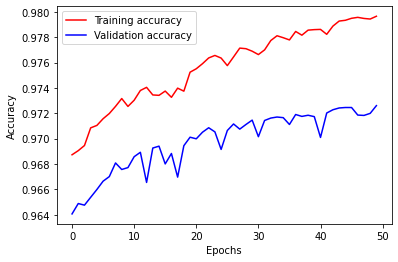

In [21]:
import matplotlib.pyplot as plt
import numpy as np

history = new_uNet.fit(imgs_train, masks_train, validation_data = (imgs_test, masks_test), epochs = 50)
training_loss = np.array(history.history['accuracy'])
validation_loss = np.array(history.history['val_accuracy'])
plt.plot(training_loss, 'r', label = "Training accuracy")
plt.plot(validation_loss, 'b', label = "Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()